In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Round 1 Submission: Facial Reconstruction from Low-Quality CCTV Footage
This notebook walks through the entire pipeline for Round 1: from data loading, preprocessing, and model training, to the generation of results for submission.



## **Data Loading and Preprocessing**

We first load the `.npz` files, resize the images to a smaller size for faster training, and normalize them. We’ll use memory-mapped loading to avoid loading the entire dataset into RAM, which is especially useful when working on low-memory systems.

In [15]:
import numpy as np
import os
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tqdm import tqdm
import tensorflow as tf
import time
import psutil
import random

In [16]:
# Set the target image shape and directory
TARGET_SHAPE = (32, 32, 3)
dataset_dir = '/content/drive/MyDrive/face-rec/dataset'

# Function to resize and normalize images
def resize_and_normalize_image(image):
    """Resize the image and normalize it between 0 and 1."""
    return resize(image, TARGET_SHAPE, preserve_range=True, anti_aliasing=True) / 255.0

# Function to load data from .npz file
def load_npz_data(file_path):
    """Load data from .npz file using memory mapping and resize the images."""
    start_time = time.time()  # Start timing
    try:
        data = np.load(file_path, mmap_mode='r')
        color_images = data['colorImages']
        # Resize images and normalize
        resized_images = np.array([resize_and_normalize_image(img) for img in color_images.transpose(3, 0, 1, 2)])
        return resized_images
    except Exception as e:
        return np.array([])  # Return empty array in case of error

# List all .npz files
file_list = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('.npz')]

# Split file list into training and validation sets
train_files, val_files = train_test_split(file_list, test_size=0.2, random_state=42)

## **Data Augmentation**
We’ll use data augmentation to generate more training data from the available images, which improves model robustness. This includes random rotations, shifts, and flips.

In [17]:
# Data Augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Custom data generator function
def data_generator(file_list, batch_size=32):
    """Custom data generator with data loading and augmentation."""
    while True:
        for i in tqdm(range(0, len(file_list), batch_size), desc="Loading Data"):
            batch_files = file_list[i:i + batch_size]
            batch_images = []
            for file in batch_files:
                images = load_npz_data(file)
                if images.size > 0:
                    batch_images.append(images)
            if not batch_images:  # If the batch is empty, skip to next iteration
                continue
            batch_images = np.concatenate(batch_images, axis=0)
            augmented_images = np.array([data_augmentation.random_transform(img) for img in batch_images])
            yield augmented_images, augmented_images


## **Model Architecture**
Here, we build a small Convolutional Neural Network (CNN) to reconstruct facial images. This network is designed to be lightweight to ensure faster training on limited hardware.

In [18]:
# Build and summarize the model
def build_facial_reconstruction_cnn(input_shape=(64, 64, 3)):
    """Create a lightweight CNN for facial reconstruction."""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')  # Output layer with 3 channels (RGB)
    ])

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=['accuracy'])
    return model

# Build the model
input_shape = (32, 32, 3)
reconstruction_model = build_facial_reconstruction_cnn(input_shape=input_shape)
reconstruction_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 8, 8, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 32, 32, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 776,579 (2.96 MB)

 Trainable params: 776,579 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

## **Training with Learning Rate Scheduler**
We’ll use a learning rate scheduler to reduce the learning rate as training progresses, which helps the model converge faster.

In [19]:
# Learning Rate Scheduler
def learning_rate_scheduler(epoch, lr):
    """Decrease learning rate after 10 epochs."""
    if epoch > 10:
        return lr * 0.1
    return lr

# Callbacks
checkpoint_callback = ModelCheckpoint(
    'best_model.keras',  # Path to save the model
    monitor='val_loss',  # Monitor validation loss
    verbose=1,          # Print out log info
    save_best_only=True, # Only save the model if the validation loss improves
    mode='min'          # Save based on minimum validation loss
)

lr_schedule_callback = LearningRateScheduler(learning_rate_scheduler)

In [20]:
# Sample a subset of files for training
def sample_file_list(file_list, sample_size):
    """Randomly sample a subset of files from the dataset."""
    return random.sample(file_list, sample_size)

# Example: Sampling 10% of the dataset
sample_size = int(len(train_files) * 0.1)
sampled_train_files = sample_file_list(train_files, sample_size)

# Example: Sampling 50% of the validation data
val_sample_size = int(len(val_files) * 0.5)  # For example, take 50%
sampled_val_files = random.sample(val_files, val_sample_size)


## **Model Training**
Finally, we train the model using the generator, ensuring that we can handle large datasets without memory overloads. Mixed precision is used for faster GPU training.

In [ ]:
# Monitor Memory Usage
def print_memory_usage():
    """Prints the current memory usage."""
    process = psutil.Process()
    memory_info = process.memory_info()
    print(f"Memory Usage: {memory_info.rss / (1024 ** 2):.2f} MB")  # RSS memory usage

# Model Training
batch_size = 32

# Callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop if no improvement for 3 epochs
    restore_best_weights=True
)

# Train the model with adjustments
history = reconstruction_model.fit(
    data_generator(sampled_train_files, batch_size=batch_size),
    steps_per_epoch=len(sampled_train_files) // batch_size,
    validation_data=data_generator(sampled_val_files, batch_size=batch_size),
    validation_steps=len(sampled_val_files) // batch_size,
    epochs=10,  # Reduced number of epochs
    callbacks=[checkpoint_callback, lr_schedule_callback, early_stopping_callback],
    verbose=2  # Verbose for training progress only
)


Loading Data:  20%|██        | 1/5 [00:58<03:52, 58.18s/it]

Epoch 1/10


Loading Data: 100%|██████████| 6/6 [06:10<00:00, 61.81s/it]

Loading Data:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 1: val_loss improved from inf to 0.07850, saving model to best_model.keras
4/4 - 759s - 190s/step - accuracy: 0.3901 - loss: 0.0765 - val_accuracy: 0.6463 - val_loss: 0.0785 - learning_rate: 0.0010
Epoch 2/10


Loading Data:  67%|██████▋   | 4/6 [10:28<03:56, 118.39s/it]


Epoch 2: val_loss improved from 0.07850 to 0.07161, saving model to best_model.keras
4/4 - 640s - 160s/step - accuracy: 0.6147 - loss: 0.0726 - val_accuracy: 0.6390 - val_loss: 0.0716 - learning_rate: 0.0010
Epoch 3/10


Loading Data: 100%|██████████| 6/6 [12:45<00:00, 127.57s/it]

Loading Data:  50%|█████     | 3/6 [06:47<06:03, 121.09s/it]


Epoch 3: val_loss improved from 0.07161 to 0.05688, saving model to best_model.keras
4/4 - 540s - 135s/step - accuracy: 0.5697 - loss: 0.0723 - val_accuracy: 0.6301 - val_loss: 0.0569 - learning_rate: 0.0010
Epoch 4/10


Loading Data: 100%|██████████| 6/6 [12:04<00:00, 120.69s/it]

Loading Data:  33%|███▎      | 2/6 [03:59<07:34, 113.55s/it]


Epoch 4: val_loss improved from 0.05688 to 0.05277, saving model to best_model.keras
4/4 - 561s - 140s/step - accuracy: 0.5783 - loss: 0.0595 - val_accuracy: 0.6355 - val_loss: 0.0528 - learning_rate: 0.0010
Epoch 5/10


Loading Data: 100%|██████████| 6/6 [11:01<00:00, 110.20s/it]

Loading Data:  17%|█▋        | 1/6 [01:55<09:35, 115.01s/it]


Epoch 5: val_loss improved from 0.05277 to 0.05260, saving model to best_model.keras
4/4 - 548s - 137s/step - accuracy: 0.6085 - loss: 0.0516 - val_accuracy: 0.5271 - val_loss: 0.0526 - learning_rate: 0.0010
Epoch 6/10


Loading Data: 100%|██████████| 6/6 [11:51<00:00, 118.60s/it]

Loading Data:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 6: val_loss improved from 0.05260 to 0.03918, saving model to best_model.keras
4/4 - 620s - 155s/step - accuracy: 0.5563 - loss: 0.0437 - val_accuracy: 0.6378 - val_loss: 0.0392 - learning_rate: 0.0010
Epoch 7/10


Loading Data: 100%|██████████| 6/6 [10:48<00:00, 108.00s/it]

Loading Data:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 7: val_loss improved from 0.03918 to 0.03666, saving model to best_model.keras
4/4 - 599s - 150s/step - accuracy: 0.6153 - loss: 0.0402 - val_accuracy: 0.6468 - val_loss: 0.0367 - learning_rate: 0.0010
Epoch 8/10


Loading Data:  67%|██████▋   | 4/6 [08:51<03:55, 117.90s/it]


Epoch 8: val_loss improved from 0.03666 to 0.03402, saving model to best_model.keras
4/4 - 552s - 138s/step - accuracy: 0.5819 - loss: 0.0378 - val_accuracy: 0.6417 - val_loss: 0.0340 - learning_rate: 0.0010
Epoch 9/10


Loading Data: 100%|██████████| 6/6 [11:12<00:00, 112.03s/it]

Loading Data:  50%|█████     | 3/6 [06:40<06:03, 121.11s/it]


Epoch 9: val_loss improved from 0.03402 to 0.03031, saving model to best_model.keras
4/4 - 532s - 133s/step - accuracy: 0.5881 - loss: 0.0309 - val_accuracy: 0.6489 - val_loss: 0.0303 - learning_rate: 0.0010
Epoch 10/10


Loading Data: 100%|██████████| 6/6 [11:30<00:00, 115.06s/it]

Loading Data:  33%|███▎      | 2/6 [04:37<08:58, 134.53s/it]


Epoch 10: val_loss did not improve from 0.03031
4/4 - 581s - 145s/step - accuracy: 0.6102 - loss: 0.0312 - val_accuracy: 0.6360 - val_loss: 0.0327 - learning_rate: 0.0010


In [ ]:
# Save the final model after training
reconstruction_model.save('final_facial_reconstruction_model.keras')

In [ ]:
# prompt: move the final_reconstruction

!mv final_facial_reconstruction_model.keras /content/drive/MyDrive/face-rec/models/


## **Generating Predictions**
After training, we generate reconstructed images from the validation set. This will be used for submission and evaluation.

In [22]:
from tensorflow.keras.models import load_model

saved_model = load_model('/content/drive/MyDrive/face-rec/models/final_facial_reconstruction_model.keras')



Loading Data:   0%|          | 0/67 [00:07<?, ?it/s]


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step


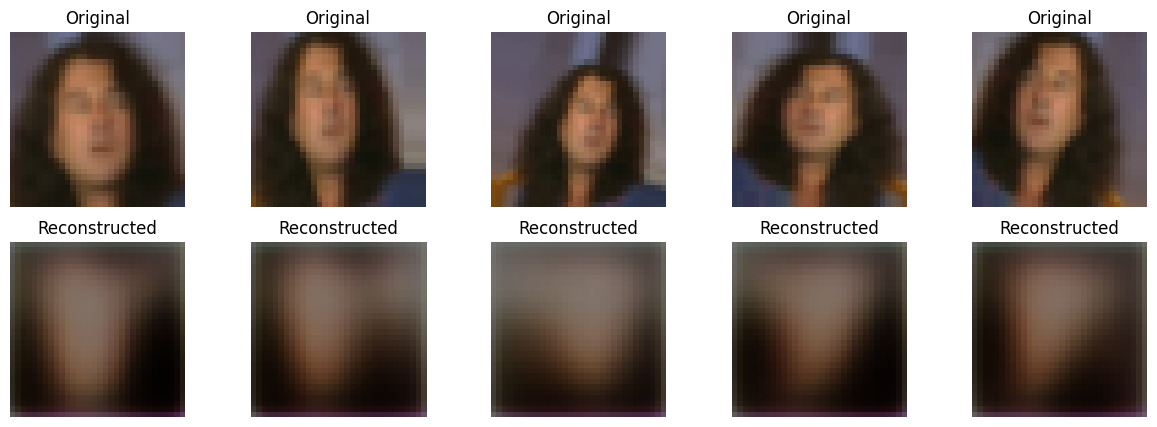

In [23]:
# Generate Predictions
import matplotlib.pyplot as plt

def plot_predictions(model, val_files, num_samples=5):
    """Plot predictions of the model on validation data."""
    batch = next(data_generator(val_files, batch_size=num_samples))
    predicted_images = model.predict(batch[0])

    fig, axs = plt.subplots(2, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        axs[0, i].imshow(batch[0][i])
        axs[0, i].set_title("Original")
        axs[0, i].axis('off')

        axs[1, i].imshow(predicted_images[i])
        axs[1, i].set_title("Reconstructed")
        axs[1, i].axis('off')

    plt.show()

# Plot some predictions
plot_predictions(saved_model, val_files)

## **Saving the Model Output**
Save the predicted results.

In [24]:
# Save the predicted results
def save_predictions(model, val_files, output_dir='/content/drive/MyDrive/face-rec/predictions/'):
     """Save the reconstructed images for submission."""
     if not os.path.exists(output_dir):
         os.makedirs(output_dir)

     for i, file in enumerate(val_files):
         batch = next(data_generator([file], batch_size=1))
         predicted_images = model.predict(batch[0])

         for j, img in enumerate(predicted_images):
             plt.imsave(os.path.join(output_dir, f'pred_{i}_{j}.png'), img)

# Save the predictions
save_predictions(saved_model, val_files)



Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step




Loading Data:   0%|          | 0/1 [00:04<?, ?it/s]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step




Loading Data:   0%|          | 0/1 [00:02<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step




Loading Data:   0%|          | 0/1 [00:03<?, ?it/s]

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step 




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step




Loading Data:   0%|          | 0/1 [00:02<?, ?it/s]

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step




Loading Data:   0%|          | 0/1 [00:02<?, ?it/s]


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step




Loading Data:   0%|          | 0/1 [00:03<?, ?it/s]

1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step




Loading Data:   0%|          | 0/1 [00:02<?, ?it/s]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step




Loading Data:   0%|          | 0/1 [00:02<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step




Loading Data:   0%|          | 0/1 [00:08<?, ?it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step




Loading Data:   0%|          | 0/1 [00:02<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step 




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step




Loading Data:   0%|          | 0/1 [00:03<?, ?it/s]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step 




Loading Data:   0%|          | 0/1 [00:02<?, ?it/s]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step




Loading Data:   0%|          | 0/1 [00:03<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step




Loading Data:   0%|          | 0/1 [00:02<?, ?it/s]


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step 




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step




Loading Data:   0%|          | 0/1 [00:07<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step




Loading Data:   0%|          | 0/1 [00:03<?, ?it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step




Loading Data:   0%|          | 0/1 [00:05<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step




Loading Data:   0%|          | 0/1 [00:10<?, ?it/s]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step




Loading Data:   0%|          | 0/1 [00:03<?, ?it/s]


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step 




Loading Data:   0%|          | 0/1 [00:03<?, ?it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step




Loading Data:   0%|          | 0/1 [00:05<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step




Loading Data:   0%|          | 0/1 [00:06<?, ?it/s]

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step




Loading Data:   0%|          | 0/1 [00:02<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step




Loading Data:   0%|          | 0/1 [00:02<?, ?it/s]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step 




Loading Data:   0%|          | 0/1 [00:03<?, ?it/s]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step




Loading Data:   0%|          | 0/1 [00:04<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step




Loading Data:   0%|          | 0/1 [00:02<?, ?it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step




Loading Data:   0%|          | 0/1 [00:05<?, ?it/s]

1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step




Loading Data:   0%|          | 0/1 [00:06<?, ?it/s]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step




Loading Data:   0%|          | 0/1 [00:02<?, ?it/s]


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step




Loading Data:   0%|          | 0/1 [00:02<?, ?it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step




Loading Data:   0%|          | 0/1 [00:03<?, ?it/s]

1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step




Loading Data:   0%|          | 0/1 [00:02<?, ?it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step 




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step




Loading Data:   0%|          | 0/1 [00:06<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step




Loading Data:   0%|          | 0/1 [00:02<?, ?it/s]


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step




Loading Data:   0%|          | 0/1 [00:05<?, ?it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step




Loading Data:   0%|          | 0/1 [00:05<?, ?it/s]


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step




Loading Data:   0%|          | 0/1 [00:02<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step 




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step 




Loading Data:   0%|          | 0/1 [00:02<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step 




Loading Data:   0%|          | 0/1 [00:06<?, ?it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step




Loading Data:   0%|          | 0/1 [00:03<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step




Loading Data:   0%|          | 0/1 [00:01<?, ?it/s]

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step




Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step




Loading Data:   0%|          | 0/1 [00:03<?, ?it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-443efca9f744>", line 15, in <cell line: 15>
    save_predictions(saved_model, val_files)
  File "<ipython-input-24-443efca9f744>", line 8, in save_predictions
    batch = next(data_generator([file], batch_size=1))
  File "<ipython-input-17-581bb8fb97a4>", line 20, in data_generator
    images = load_npz_data(file)
  File "<ipython-input-16-e19fd2d12069>", line 18, in load_npz_data
    resized_images = np.array([resize_and_normalize_image(img) for img in color_images.transpose(3, 0, 1, 2)])
  File "<ipython-input-16-e19fd2d12069>", line 18, in <listcomp>
    resized_images = np.array([resize_and_normalize_image(img) for img in color_images.transpose(3, 0, 1, 2)])
  File "<ipython-input-16-e19fd2d12069>", line 8, in resize_and_normalize_image
    return resize(image, TAR

TypeError: object of type 'NoneType' has no len()